# Titanic Dataset - Your first teacher

In [47]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [58]:
# read data
df = pd.read_csv('train.csv')
df.info()

# separate columns to Num and Cat
TARGET_VAR = 'Survived'
NUM_FEAT = ['Age', 'SibSp', 'Parch', 'Fare']
CAT_FEAT = ['Pclass', 'Sex', 'Embarked']
OTHERS = ['Name', 'Cabin'] # Luxury


# Concerns:
# Age - some null values may need mean imputation --> can we impute within classes for better accuracy???
# Cabin - many nulls, but surely is important let's see what we can do 

# datatypes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### grouping of features

Index
* PassengerId - just an index

Target Variable
* Survived - 0 = died, 1 = survived

Physical Features (Estimated impact S,M,L)
* Name (S) - needs text feature processing
* Sex (L)
* Age (L)
* SibSp (M)
* Parch (M)

Titanic Features
* Pclass (L)
* Ticket (S) - ticket number, should not impact much
* Fare (S)
* Cabin (M) - Position on the cabin will be important can be closer to the sinking point
* Embarked (S)

In [49]:
df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Allison, Master. Hudson Trevor",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


## EDA

0    549
1    342
Name: Survived, dtype: int64

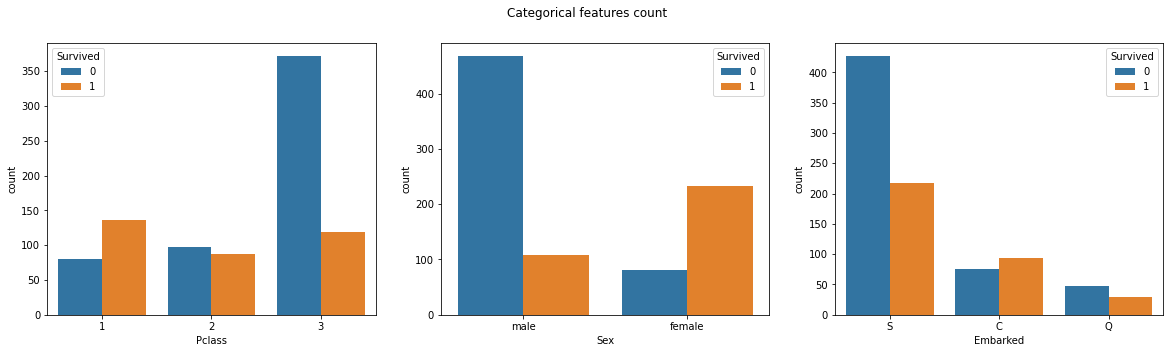

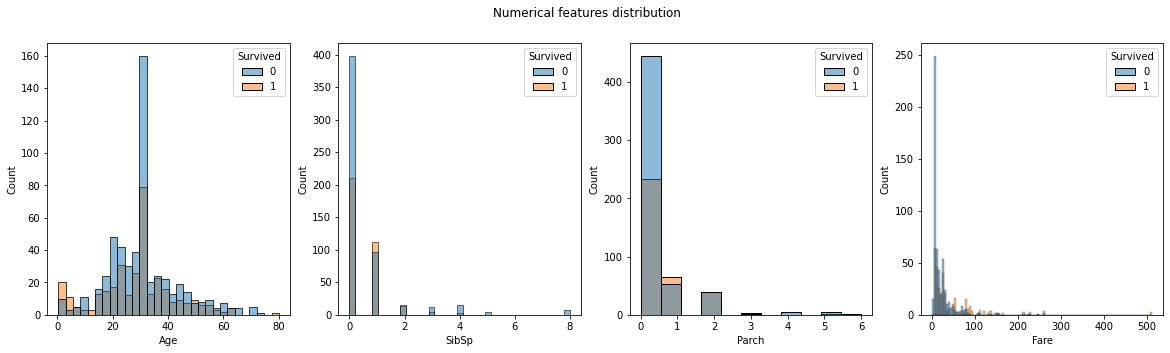

In [57]:
def examine_df(df):
    '''
    Examines the df
    - count instances of each target variable
    - count instances of each target variable with respect to categorical features
    - plot histograms of numerical features
    '''
    # count target var
    display(df[TARGET_VAR].value_counts())

    # cat features
    fig, ax = plt.subplots(1,len(CAT_FEAT),figsize=(20,5))
    for i in range(len(CAT_FEAT)):
        sns.countplot(ax=ax[i], data=df, x=CAT_FEAT[i], hue=TARGET_VAR)
    fig.suptitle('Categorical features count')
    plt.show()

    # num feat
    fig, ax = plt.subplots(1,len(NUM_FEAT),figsize=(20,5))
    for i in range(len(NUM_FEAT)):
        sns.histplot(ax=ax[i], data=df, x=NUM_FEAT[i], hue=TARGET_VAR)
    fig.suptitle('Numerical features distribution')
    plt.show()

examine_df(df)
# PClass - first class got > 0.5 survival rate, 3rd class died way more
# Sex - male died more
# Embarked - most were out of S port
# All except age are kind of exponentially distributed
# Age is kind of a skewed normal


## Preprocessing

In [51]:
# deal with missing values
print('Before')
display(df['Age'].describe())

print('\nAfter')
df['Age'].fillna(df['Age'].mean(), inplace=True)
display(df['Age'].describe())

Before


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


After


count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [52]:
# train test split
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=69)

# separate features and target variables
X_train_num, X_train_cat, y_train = df_train[NUM_FEAT], df_train[CAT_FEAT], df_train[TARGET_VAR]
X_test_num, X_test_cat, y_test = df_test[NUM_FEAT], df_test[CAT_FEAT], df_test[TARGET_VAR]

0    490
1    311
Name: Survived, dtype: int64

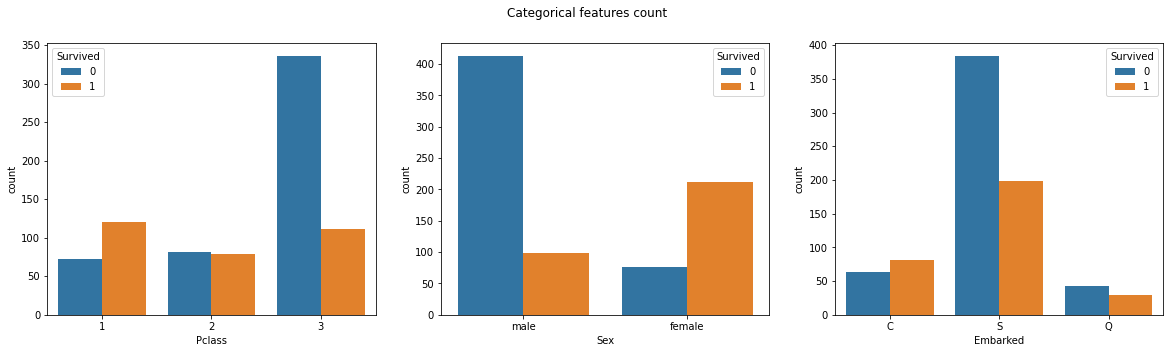

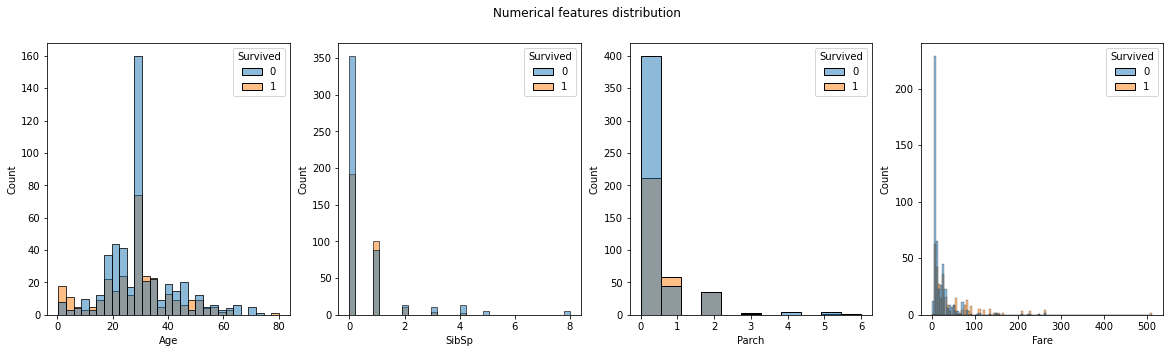

0    59
1    31
Name: Survived, dtype: int64

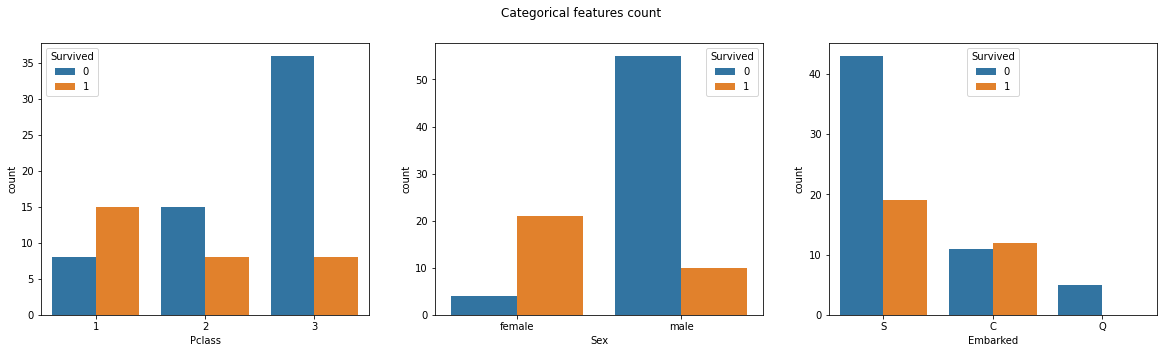

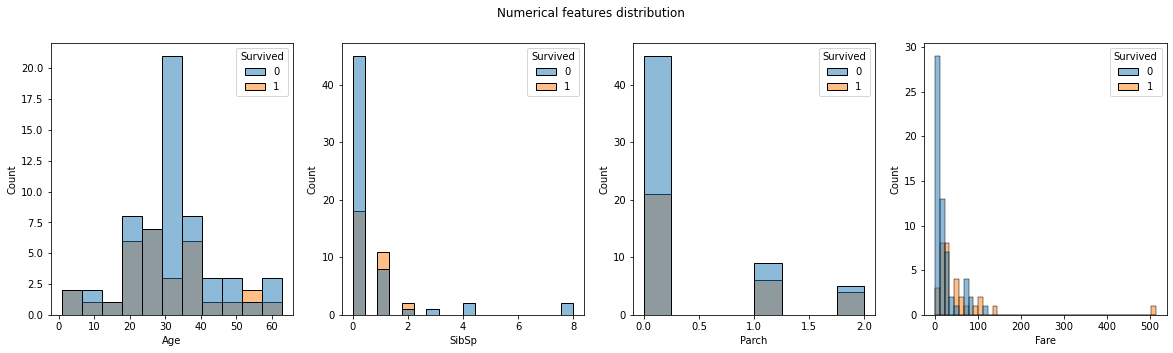

In [53]:
# check training data 
examine_df(df_train)
examine_df(df_test)

## First pass simple model with numerical features only

performance metrics
* accuracy
* confusion matrix - precision, recall, f1
* ROC&AUC
* logloss 

what does each metric tell us and what should we care the most????
https://www.kdnuggets.com/2020/04/performance-evaluation-metrics-classification.html

DUMB MODEL = saying that all are dead will get an accuracy of ~66% (59/90 ppl died in the test set)

In [82]:
# import metrics
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, plot_roc_curve, log_loss

def evaluate_cf(cf, X_train, y_train, X_test, y_test):
    # fit and predict
    cf.fit(X_train, y_train)
    y_pred = cf.predict(X_test)

    # metrics
    print('Accuracy = {}'.format(accuracy_score(y_test, y_pred)))
    print('Logloss = {}'.format(log_loss(y_test, y_pred)))
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(lr, X_test, y_test, normalize='true')
    plot_roc_curve(lr, X_test, y_test)


Accuracy = 0.7
Logloss = 10.361686224968551
              precision    recall  f1-score   support

           0       0.72      0.90      0.80        59
           1       0.62      0.32      0.43        31

    accuracy                           0.70        90
   macro avg       0.67      0.61      0.61        90
weighted avg       0.68      0.70      0.67        90



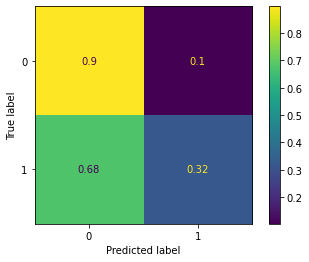

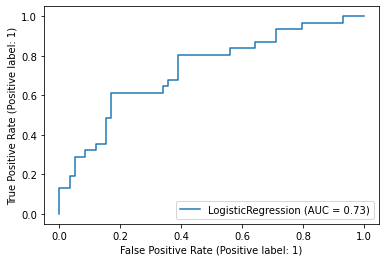

In [83]:
# logistic regression basic model
from sklearn.linear_model import LogisticRegression

evaluate_cf(LogisticRegression(), X_train_num, y_train, X_test_num, y_test)

In [77]:
# experiment on scalers